In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


In [2]:
import h5py

def setup(filepath):
    with h5py.File(filepath, 'r') as f:
        X_train = f["train_x"][:]
        y_train = f["train_y"][:]
        group_train = f["train_groups"][:]
        train_wells = f["train_groups"].attrs["well_names"]        
        
        X_test = f["test_x"][:]
        y_test = None
#         y_test = f["test_y"]
        group_test = f["test_groups"][:]
        test_wells = f["test_groups"].attrs["well_names"]

    return X_train, y_train, group_train, X_test, y_test, group_test, (train_wells, test_wells)

X_train, y_train, group_train, X_test, y_test, group_test, well_names = setup('../datasets/seg_2016_facies/la_team_5_data.h5py')

In [3]:
# XGBClassifier(learning_rate=0.12,
#               max_depth=3,
#               min_child_weight=10,
#               n_estimators=150,
#               seed=seed,
#               colsample_bytree=0.9)

In [4]:
from os import path
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')
print(filepath)

/Users/stevejpurves/dev/swung/ray_playground/datasets/seg_2016_facies/la_team_5_data.h5py


In [14]:
from sklearn.model_selection import LeavePGroupsOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy.signal import medfilt
from filelock import FileLock

def e2e_train_and_test(config, **kwargs):
    
    #threadsafe
#     filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')
    with FileLock("./data.lock"):
        X, y, groups, X_test, y_test, group_test, well_names = setup(kwargs['filepath'])
    
    # chose your CV strategy
    splitter = LeavePGroupsOut(1)
    
    # run k fold training and validation
    f1_scores = [] # keep hold of all individual scores
    for train_ind, val_ind in splitter.split(X, y, groups=groups):
        pipeline = make_pipeline(RobustScaler(),
                                  XGBClassifier())

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[val_ind])
        
        f1_scores.append(f1_score(y_pred, y[val_ind], average='micro'))
    
        # Clean isolated facies for each well
        y_pred = medfilt(y_pred, kernel_size=5)
    
    # use tunes reporter
    tune.track.log(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

In [6]:
tuning_config = {
    'xgbclassifier__learning_rate': 0.12,
    'xgbclassifier__max_depth': 3,
    'xbgclassifier__min_child_weight' :10,
    'xbgclassifier__n_estimators': 150,
    'xgbclassifier__seed':1773,
    'xgbclassifier__colsample_bytree':0.9
}

In [7]:
ray_tuning_config = {
    'xgbclassifier__learning_rate': tune.loguniform(0.001, 0.5),
    'xgbclassifier__max_depth': tune.randint(1, 10),
    'xgbclassifier__min_child_weight': tune.loguniform(0.1,100),
    'xgbclassifier__n_estimators': tune.randint(5,200),
    'xgbclassifier__colsample_bytree': tune.choice([0.4, 0.6, 0.8, 1.0]),
    'xgbclassifier__lambda': tune.choice([0,1]),
    'xgbclassifier__seed': 42
}

In [8]:
ray.shutdown()
ray.init(num_cpus=6, num_gpus=0, include_webui=True)

2020-06-05 11:24:39,757	INFO resource_spec.py:204 -- Starting Ray with 4.25 GiB memory available for workers and up to 2.13 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-05 11:24:40,202	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.36',
 'raylet_ip_address': '192.168.1.36',
 'redis_address': '192.168.1.36:52873',
 'object_store_address': '/tmp/ray/session_2020-06-05_11-24-39_747633_3205/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-05_11-24-39_747633_3205/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-05_11-24-39_747633_3205'}

In [15]:
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')

def e2e_seg(config):
    return e2e_train_and_test(config, filepath=filepath)

analysis = tune.run(
                e2e_seg,
                config=ray_tuning_config,
                num_samples=2, # Specify the number of samples to make from (non grid) distributions
                resources_per_trial=dict(cpu=1, gpu=0),
                local_dir="~/ray_results/seg_facies")

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators
e2e_seg_00000,RUNNING,,0.8,1,0.00610262,3,0.276112,5
e2e_seg_00001,PENDING,,0.4,0,0.0016293,8,0.122872,136


(pid=3235) 2020-06-05 11:30:34,588	INFO trainable.py:217 -- Getting current IP.
(pid=3239) 2020-06-05 11:30:34,588	INFO trainable.py:217 -- Getting current IP.


2020-06-05 11:30:36,658	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00000:
  date: 2020-06-05_11-30-36
  done: true
  experiment_id: 90d7159fb4b94ef8ab8c273ddc0f90a6
  experiment_tag: 0_xgbclassifier__colsample_bytree=0.8,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.0061026,xgbclassifier__max_depth=3,xgbclassifier__min_child_weight=0.27611,xgbclassifier__n_estimators=5
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.541187033164128
  node_ip: 192.168.1.36
  pid: 3239
  std_f1_score: 0.07343423892001634
  time_since_restore: 2.0633130073547363
  time_this_iter_s: 2.0633130073547363
  time_total_s: 2.0633130073547363
  timestamp: 1591353036
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  


2020-06-05 11:31:58,594	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00001:
  date: 2020-06-05_11-31-58
  done: true
  experiment_id: 2f66613c96b04605880d9cf5c92d3889
  experiment_tag: 1_xgbclassifier__colsample_bytree=0.4,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.0016293,xgbclassifier__max_depth=8,xgbclassifier__min_child_weight=0.12287,xgbclassifier__n_estimators=136
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5774002787855361
  node_ip: 192.168.1.36
  pid: 3235
  std_f1_score: 0.1027799691103185
  time_since_restore: 83.99692392349243
  time_this_iter_s: 83.99692392349243
  time_total_s: 83.99692392349243
  timestamp: 1591353118
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00001'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,1,0.00610262,3,0.276112,5,0,2.06331
e2e_seg_00001,TERMINATED,,0.4,0,0.0016293,8,0.122872,136,0,83.9969


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,1,0.00610262,3,0.276112,5,0,2.06331
e2e_seg_00001,TERMINATED,,0.4,0,0.0016293,8,0.122872,136,0,83.9969


In [10]:
print("Best config: ", analysis.get_best_config(metric="mean_f1_score"))

Best config:  {'xgbclassifier__learning_rate': 0.0018266549202181717, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 0.16990866286192743, 'xgbclassifier__n_estimators': 39, 'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__lambda': 1, 'xgbclassifier__seed': 42}


In [11]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

In [12]:
top_n_df.head()

,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,iterations_since_restore,experiment_tag,config/xgbclassifier__colsample_bytree,config/xgbclassifier__lambda,config/xgbclassifier__learning_rate,config/xgbclassifier__max_depth,config/xgbclassifier__min_child_weight,config/xgbclassifier__n_estimators,config/xgbclassifier__seed,logdir
1,0.548415,0.064307,True,1,0,120.242662,NaN,NaN,85f2310da4b643a8adf603356bc44f77,2020-06-05_11-26-58,...,1,"1_xgbclassifier__colsample_bytree=0.6,xgbclass...",0.6,1,0.001827,8,0.169909,39,42,/Users/stevejpurves/ray_results/seg_facies/e2e...
0,0.544668,0.050587,True,0,0,55.467646,NaN,NaN,757e708765e140ec9110d18fb540e941,2020-06-05_11-25-53,...,1,"0_xgbclassifier__colsample_bytree=0.6,xgbclass...",0.6,1,0.481177,2,1.487259,67,42,/Users/stevejpurves/ray_results/seg_facies/e2e...


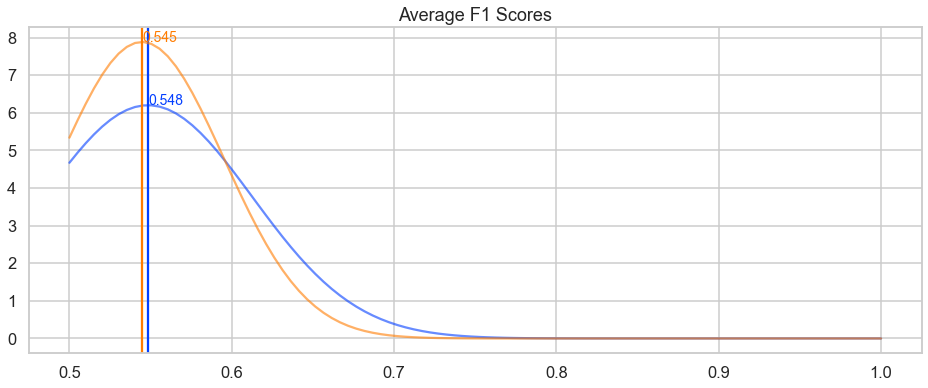

In [13]:
plot_some_tune_results(top_n_df, (0.5, 1.0))

In [ ]:
%load_ext tensorboard
from tensorboard import notebook 
%tensorboard --logdir "~/ray_results/seg_facies"
notebook.display(height=1000)

In [10]:
ray.shutdown()

In [ ]:
ray.init(address='auto', redis_password='5241590000000000')